In [280]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser
from dateutil import rrule

from sklearn.metrics import auc, roc_curve, classification_report

#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

# Goals 
1. For each user, determine her country based on the numeric IP address. 
2. **[Your principles in detecting frauds]:**Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model. => What kinds of users are more likely to be classified as at risk? What are their characteristics?
3. **[Product Recommendation]:**From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output => Two factor authorization on specific group of users

# 1. Data Preview

In [281]:
# Load the fraud detection project dataset
data = pd.read_csv("Fraud_Data.csv",sep=",")
ip = pd.read_csv("IpAddress_to_Country.csv", sep = ",")
# Let us first develop a preview of the fraud database
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [401]:
# Let us first develop a preview of the ip address book
print(f"The ip address book consists of {ip.shape[0]} rows and {ip.shape[1]} columns, with no missing value\n")
ip.head()


The ip address book consists of 138846 rows and 3 columns, with no missing value



,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [283]:
# Exploring the data types, number of unique values and missing values
print(f"The transaction dataset consists of {data.shape[0]} rows and {data.shape[1]} columns, with no missing value\n")
print("Since the number of unique user_id matches the number of rows, it is a first-time transaction database \n\
That is to say, each row represents the first-time transaction initiated by that specific customer")
pd.DataFrame({"data_types":data.dtypes, 
          "value_counts": data.nunique(),
          "null_counts": data.isnull().sum()}).set_index(data.dtypes.index)

The transaction dataset consists of 151112 rows and 11 columns, with no missing value

Since the number of unique user_id matches the number of rows, it is a first-time transaction database 
That is to say, each row represents the first-time transaction initiated by that specific customer


,data_types,value_counts,null_counts
user_id,int64,151112,0
signup_time,object,151112,0
purchase_time,object,150679,0
purchase_value,int64,122,0
device_id,object,137956,0
source,object,3,0
browser,object,5,0
sex,object,2,0
age,int64,58,0
ip_address,float64,143512,0


In [284]:
# Next, let's take a look at the descriptive statistics
print("For numeric variables: \n",data.describe(),"\n")
print("For categorical variables: \n", data.describe(include = "object"))

For numeric variables: 
              user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.285024       18.322762       8.617733  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209350e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000      154.000000      76.000000  4.294850e+09   

               class  
count  151112.000000  
mean        0.093646  
std         0.291336  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000   

For categorical variables: 
                 signup_time        purchase_time      device_id  source  \
count                151112             

# 2. Data Cleaning

## 2-1. Convert numerical labels to categorical variables

In [285]:
# user_id

## 2-2. Determine country based on user's IP address

In [286]:
# Create a mutual key and implement a cartesian join
def map_country(ip_address, ip):
    condition = (ip_address >=ip.lower_bound_ip_address) & (ip_address <= ip.upper_bound_ip_address)
    if pd.DataFrame(condition).sum().values == 0:
        return "no_matched_country"
    else:
        return ip.loc[condition,"country"].values

In [287]:
data["country"] = ""

import time
time_start=time.time()

for ip_address in data.ip_address:
    data.loc[data.ip_address == ip_address,"country"] = map_country(ip_address,ip)
    
time_end=time.time()
print('totally cost',round((time_end-time_start)/60),"minutes")

totally cost 22 minutes


In [290]:
backup_data = data

## 2-3. Signup_time & Purchase_time
(1) Convert signup time and purchase time to ddatetime datatype
(2) Create a time difference between signup_time and purchase time

In [291]:
data["signup_time"] = list(map(lambda x: datetime.fromisoformat(x),data.signup_time))
data["purchase_time"] =list(map(lambda x: str_date_transform(x),data.purchase_time))
data["signup_to_pur_time"] = list(map(lambda s_time, p_time: round((p_time - s_time).seconds/3600),
                                      data.purchase_time, data.signup_time))

In [292]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_to_pur_time
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,20
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,19
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,24
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,no_matched_country,7
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,12


In [293]:
backup_data_2 = data

# 3. Exploratory Data Analysis

## 3-1. Single Variate

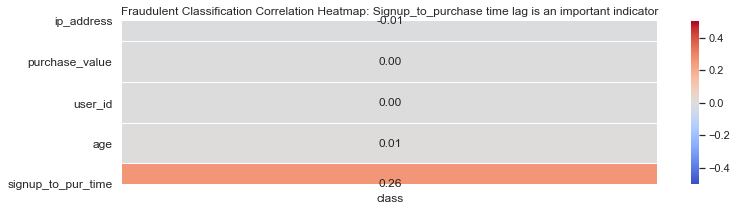

In [294]:
# Correlation with the target variable
sns.set(style="white",context="talk")
corr_data  = data.corr()

plt.figure(figsize=(12, 3))
sns.set(font_scale=1)
ax = sns.heatmap(corr_data.loc[:,['class']].drop("class",axis=0).sort_values(by="class"),fmt='.2f',cbar_kws={"shrink": 1},
               annot=True,annot_kws={"size": 12} ,vmax=0.5,vmin=-0.5,cmap='coolwarm',linewidths=0.05,linecolor='white')
ax.set(title= "Fraudulent Classification Correlation Heatmap: Signup_to_purchase time lag is an important indicator")
ax.tick_params(labelsize=12)

### 3-1-0. Fraud Distribution

In [295]:
pd.DataFrame({
          "value_counts": data["class"].value_counts(),
          "value_percentage": round(data["class"].value_counts()/data["class"].count(),2)})

,value_counts,value_percentage
0,136961,0.91
1,14151,0.09


### 3-1-1. Purchase value
**Hypothesis 1:** Fraud tends to cluster around low-purchase-value orders, in order to diversify the risk and hide from attention

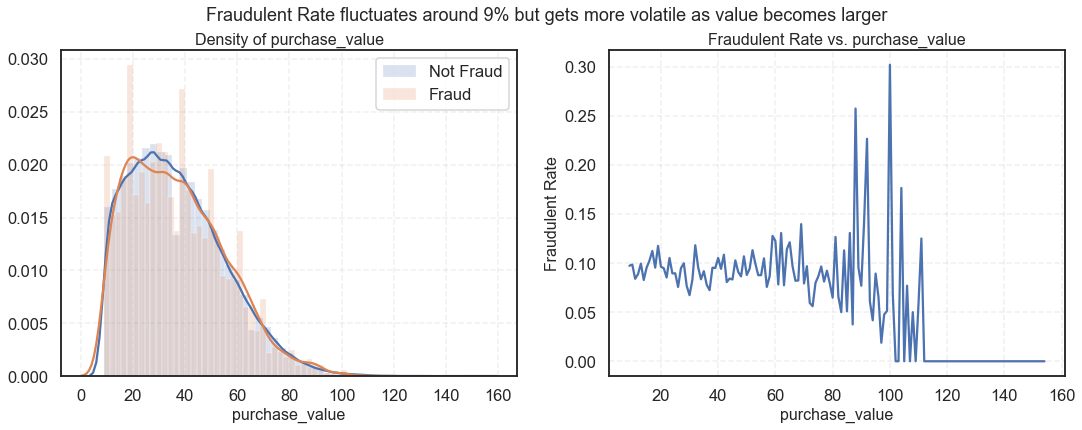

In [296]:
# Visualization of different sources
sns.set(style="white",context="talk")
grouped = data.groupby('purchase_value')["class"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['class'] == 0]['purchase_value'],
             label='Not Fraud', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['class'] == 1]['purchase_value'], 
             label='Fraud', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of purchase_value', fontsize=16)
axes[0].set_xlabel('purchase_value',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)


#sns.relplot(x = "purchase_value",y="class", data = data,kind = "line",ci = None,ax = axes[1])
axes[1].plot(grouped['purchase_value'], grouped['class'])
axes[1].set_title('Fraudulent Rate vs. purchase_value', fontsize=16)
axes[1].set_xlabel('purchase_value',fontsize = 16)
axes[1].set_ylabel('Fraudulent Rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("Fraudulent Rate fluctuates around 9% but gets more volatile as value becomes larger", fontsize = 18)
plt.show()

Cost of False positive = Purchase Value for this transaction (we fail to collect this GMV) \
Cost of False negative = Purchase Value for this transaction (we forgo this GMV)

In [297]:
data.groupby("class").purchase_value.mean().reset_index()

,class,purchase_value
0,0,36.929418
1,1,36.993004


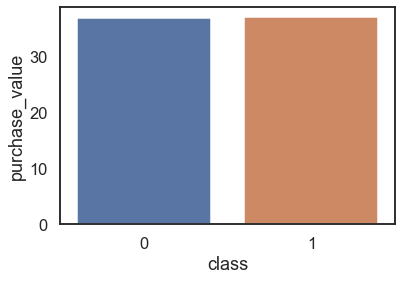

In [298]:
sns.barplot(x = "class", y = "purchase_value", data = data.groupby("class").purchase_value.mean().reset_index())


### 3-1-2. Signup_to_purchase time difference
It is unlikely for a customer to immediately commit an order right after he/she signed up an account

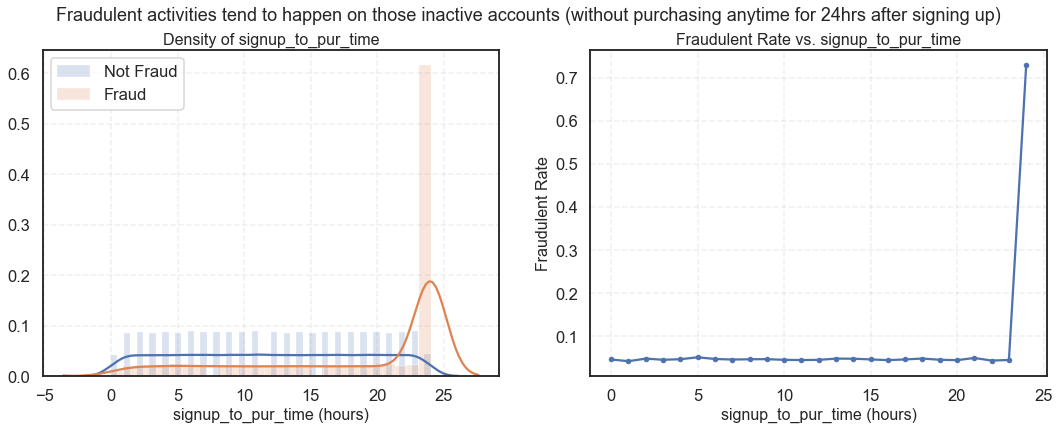

In [299]:
# Visualization of different sources
sns.set(style="white",context="talk")
grouped = data.groupby('signup_to_pur_time')["class"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['class'] == 0]['signup_to_pur_time'],
             label='Not Fraud', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['class'] == 1]['signup_to_pur_time'], 
             label='Fraud', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of signup_to_pur_time', fontsize=16)
axes[0].set_xlabel('signup_to_pur_time (hours)',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)

axes[1].plot(grouped['signup_to_pur_time'], grouped['class'],".-")
axes[1].set_title('Fraudulent Rate vs. signup_to_pur_time', fontsize=16)
axes[1].set_xlabel('signup_to_pur_time (hours)',fontsize = 16)
axes[1].set_ylabel('Fraudulent Rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("Fraudulent activities tend to happen on those inactive accounts (without purchasing anytime for 24hrs after signing up)", fontsize = 18)
plt.show()

### 3-1-3. Signup or Purchase during midnight  (to-do)

### 3-1-4. Country

In [328]:
country_fraud = pd.DataFrame(data.groupby("country").agg({"class":"mean","user_id":"count"}).sort_values(by = "class",ascending = False))
country_fraud.columns = ["fraud_rate","cnt_users"]
country_fraud

,fraud_rate,cnt_users
country,,
Turkmenistan,1.000000,1
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Virgin Islands (U.S.),0.333333,3
...,...,...
Cayman Islands,0.000000,4
Maldives,0.000000,2
Madagascar,0.000000,1


In [334]:
country_fraud[country_fraud.fraud_rate > 0.2]

,fraud_rate,cnt_users
country,,
Turkmenistan,1.000000,1
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Virgin Islands (U.S.),0.333333,3
Ecuador,0.264151,106
Tunisia,0.262712,118
Peru,0.260504,119
Bolivia,0.245283,53


### 3-1-5. Source

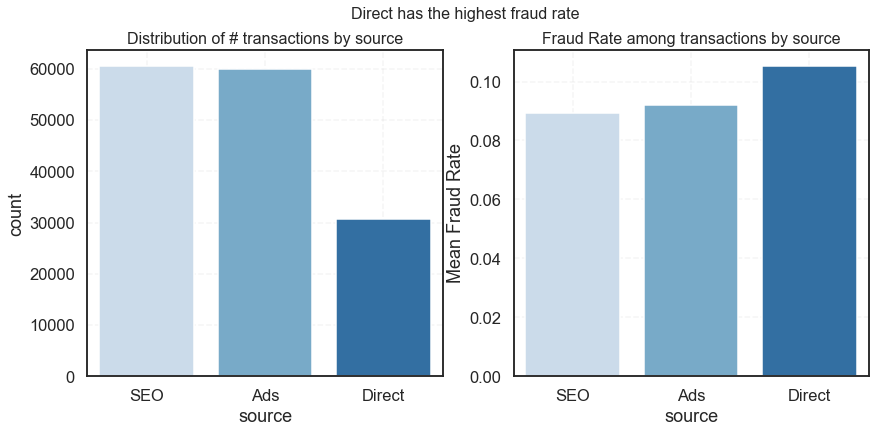

In [338]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(x='source', data=data,ax=axes[0],palette=sns.color_palette("Blues",3))
axes[0].set_title('Distribution of # transactions by source', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="source")["class"].count().reset_index()

sns.barplot(x='source', y='class', data=data,ci=0,ax=axes[1],palette=sns.color_palette("Blues",3))
axes[1].set_title('Fraud Rate among transactions by source', fontsize=16)
axes[1].set_ylabel("Mean Fraud Rate")
axes[1].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="source")["class"].mean().reset_index()


fig.suptitle("Direct has the highest fraud rate", fontsize = 16)
plt.show()

### 3-1-6. Browser

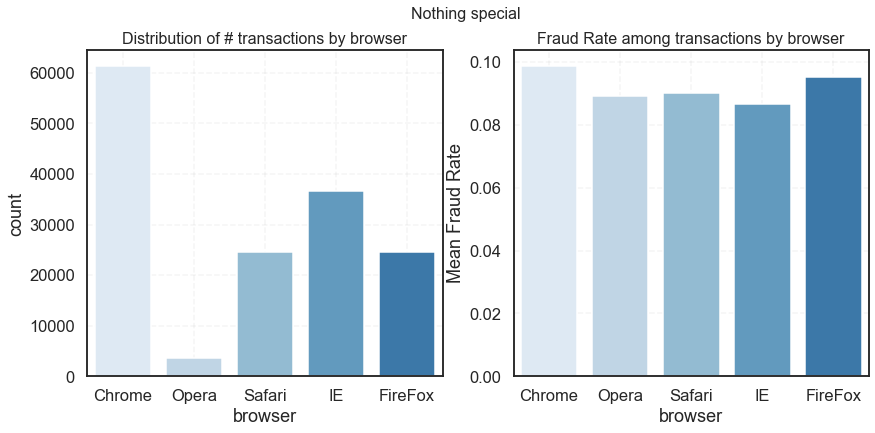

In [306]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(x='browser', data=data,ax=axes[0],palette=sns.color_palette("Blues"))
axes[0].set_title('Distribution of # transactions by browser', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="browser")["class"].count().reset_index()

sns.barplot(x='browser', y='class', data=data,ci=0,ax=axes[1],palette=sns.color_palette("Blues"))
axes[1].set_title('Fraud Rate among transactions by browser', fontsize=16)
axes[1].set_ylabel("Mean Fraud Rate")
axes[1].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="browser")["class"].mean().reset_index()


fig.suptitle("Nothing special", fontsize = 16)
plt.show()

## 3-2. Multi-Variate Analysis

Most of the variables are not correlated with each other, except for our time difference in commiting an order right after signing up

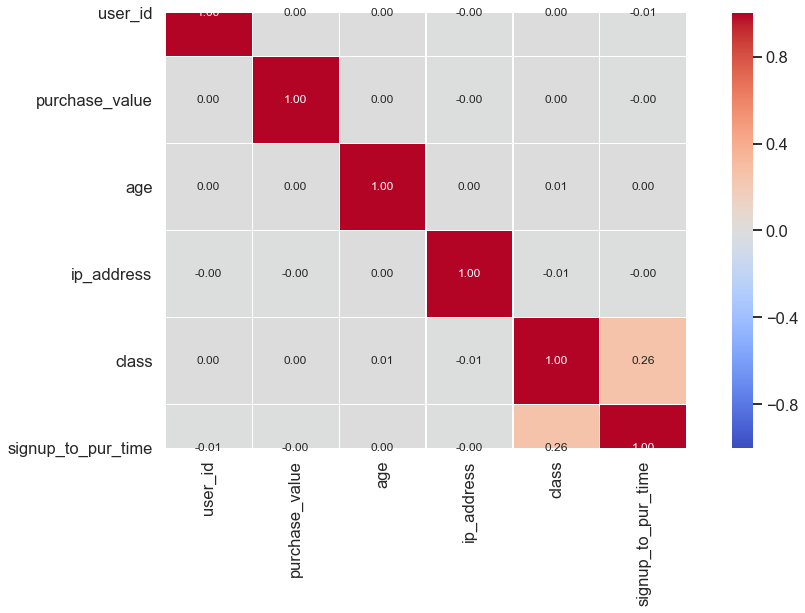

In [339]:
# Plot the correlation heat map among numeric data
sns.set(style="white",context="talk")
plt.subplots(figsize=(16,8))
sns.heatmap(corr_data, square=True, cmap = "coolwarm",fmt='.2f',cbar_kws={"shrink": 1},
               annot=True,annot_kws={"size": 12} ,vmax=1,vmin=-1,linewidths=0.05,linecolor='white')
plt.show()

### 3-2-1. Same Device ID but Identified in Different Countries

In [347]:
dup_device = data[data.duplicated("device_id",keep=False)]
dup_country_device = dup_device.groupby("device_id").country.nunique().sort_values(ascending = False).reset_index()
mul_country_device = dup_country_device[dup_country_device.country>1]
mul_country_device.columns = ["device_id","cnt_diff_countries"] 
mul_country_device["cross_country_device"] = 1
mul_country_device

,device_id,cnt_diff_countries,cross_country_device
0,YLDDOCJIVHEJV,4,1
1,ZGZRTJJZHPFXA,3,1
2,CPSDECQLSMHGK,3,1
3,QKCFXAKWCADLJ,3,1
4,PRNCPFDBZZFCH,3,1
...,...,...,...
4468,YXAUBSPCLCENI,2,1
4469,YUGRAUEYVUFAW,2,1
4470,PLUHHELLMPAJE,2,1
4471,RKWVWJGATUBJX,2,1


In [348]:
# Merge back to the main dataset
data = pd.merge(left = data, right = mul_country_device, how = "left",on = "device_id")
data["cross_country_device"] = data["cross_country_device"].fillna(0)
data["cnt_diff_countries"] = data["cnt_diff_countries"].fillna(1)
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_to_pur_time,cnt_diff_countries,cross_country_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,20,NaN,0.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,19,NaN,0.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,24,NaN,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,no_matched_country,7,NaN,0.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,12,NaN,0.0


### 3-2-2. Same IP Address but with different gender and age (Hypothesis invalidated)
Since the user_ids are all distinct here, I use gender and age to determine if both IP address refers to the same person \
**Assumption 1: customers will fill in their real gender and age information** \
**Assumption 2: The purchasers are always the true account owners, any other people using that account are suspected of conducting fradulent activities**

In [350]:
dup_ip = data[data.duplicated("ip_address",keep=False)]
dup_ip = dup_device.groupby("ip_address")[["sex","age"]].nunique().reset_index()
dup_ip.columns = ["ip_address","cnt_diff_sex","cnt_diff_age"]
dup_ip

,ip_address,cnt_diff_sex,cnt_diff_age
0,1.278431e+06,1,1
1,1.617889e+06,1,1
2,1.865238e+06,1,1
3,2.184848e+06,1,1
4,2.278096e+06,1,1
...,...,...,...
11726,4.293762e+09,1,1
11727,4.293860e+09,1,1
11728,4.294131e+09,1,1
11729,4.294643e+09,1,1


In [356]:
dup_ip.nunique()

ip_address      11731
cnt_diff_sex        1
cnt_diff_age        1
dtype: int64

In [353]:
mul_sex_dup_ip = dup_ip[dup_ip.cnt_diff_sex > 1].sort_values(by="cnt_diff_sex",ascending = False)
mul_sex_dup_ip

,ip_address,cnt_diff_sex,cnt_diff_age


In [354]:
mul_age_dup_ip = dup_ip[dup_ip.cnt_diff_age > 1].sort_values(by="cnt_diff_age",ascending = False)
mul_age_dup_ip

,ip_address,cnt_diff_sex,cnt_diff_age


# 4. Modeling

### 4-1. Random Forest 

In [388]:
data_dm = pd.get_dummies(data)
data_dm.head()

,purchase_value,age,ip_address,class,signup_to_pur_time,cnt_diff_countries,cross_country_device,source_Ads,source_Direct,source_SEO,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_no_matched_country
0,34,39,7.327584e+08,0,20,1.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,16,53,3.503114e+08,0,19,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,53,2.621474e+09,1,24,1.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,44,41,3.840542e+09,0,7,1.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,39,45,4.155831e+08,0,12,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [390]:
x = data_dm.drop(["class"],axis=1)
y = data_dm["class"]

In [391]:
# hold out 20% as validation dataset for evaluation purpose
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [392]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(oob_score = True, max_features='auto' ,random_state=10)
rf_parameters = {"n_estimators":[50,80,100], "max_depth":[3,5,7], "min_samples_split" :[2,5,8], "min_samples_leaf":[2,5,8]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "roc_auc", n_iter = 15)
rf_random_search.fit(x_train, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train, y_train))

{'n_estimators': 80, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 7}
0.9067905268469423


In [420]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def rfe_cv(clf, x_train, y_train, min_features_to_select):

    rfecv = RFECV(estimator = clf, step=1, cv=StratifiedKFold(2),min_features_to_select = min_features_to_select,
                  scoring='roc_auc')

    rfecv.fit(x_train, y_train.values.ravel())
    print(f"Optimal number of features : {rfecv.n_features_}, the optimal roc_auc score: {rfecv.grid_scores_.max()}\n")
    print(f"The {rfecv.n_features_} features selected: {x_train.columns[rfecv.support_].values}")

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize = (12,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, marker = "o", markersize = 3)
    #plt.plot(range(len(rfecv.grid_scores_)),
     #        rfecv.grid_scores_, marker = "o", markersize = 3)
    plt.grid(linestyle="--", alpha=0.3)
    plt.axvline(x = rfecv.n_features_, ls=":",c="green") 
    #plt.axhline(y = rfecv.grid_scores_.max(), ls=":", c="green")
    plt.text(rfecv.n_features_, rfecv.grid_scores_.max(),(rfecv.n_features_,round(rfecv.grid_scores_.max(),4)),color='green')
    plt.show()
    return rfecv

Optimal number of features : 20, the optimal roc_auc score: 0.8287635438163495

The 20 features selected: ['purchase_value' 'age' 'ip_address' 'signup_to_pur_time'
 'cnt_diff_countries' 'cross_country_device' 'source_Ads' 'source_Direct'
 'source_SEO' 'browser_Chrome' 'browser_FireFox' 'browser_IE' 'sex_F'
 'sex_M' 'country_Ecuador' 'country_Luxembourg' 'country_New Zealand'
 'country_Sri Lanka' 'country_Tunisia' 'country_no_matched_country']


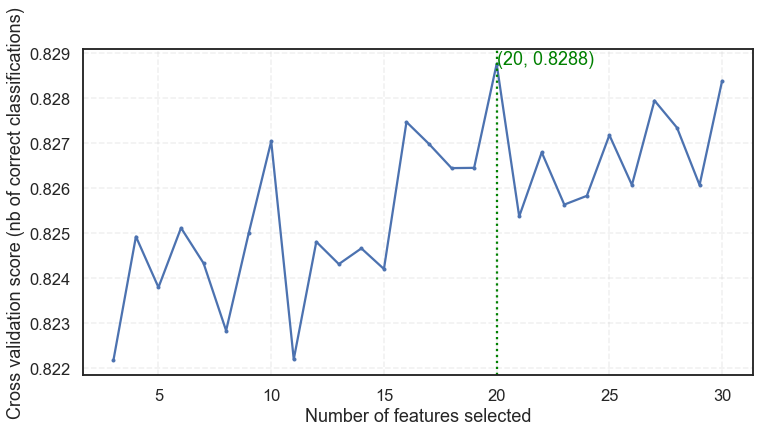

In [421]:
rf_rfecv = rfe_cv(rf_clf_best, x_train, y_train, min_features_to_select = 3)

In [422]:
rf_parameters = {"n_estimators":[40,50,60], "max_depth":[4,5,6], "min_samples_split" :[4,5,6], "min_samples_leaf":[7,8,9]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "neg_log_loss", n_iter = 15)
rf_random_search.fit(x_train[x_train.columns[rf_rfecv.support_].values], y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train[x_train.columns[rf_rfecv.support_].values], y_train))

{'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_depth': 6}
0.9398456435242247


In [423]:
fea_imp = pd.DataFrame({"importance":[round(x,4) for x in rf_clf_best.feature_importances_],
                        "feature":x_train.columns[rf_rfecv.support_].values}).sort_values(by = "importance", ascending = False)


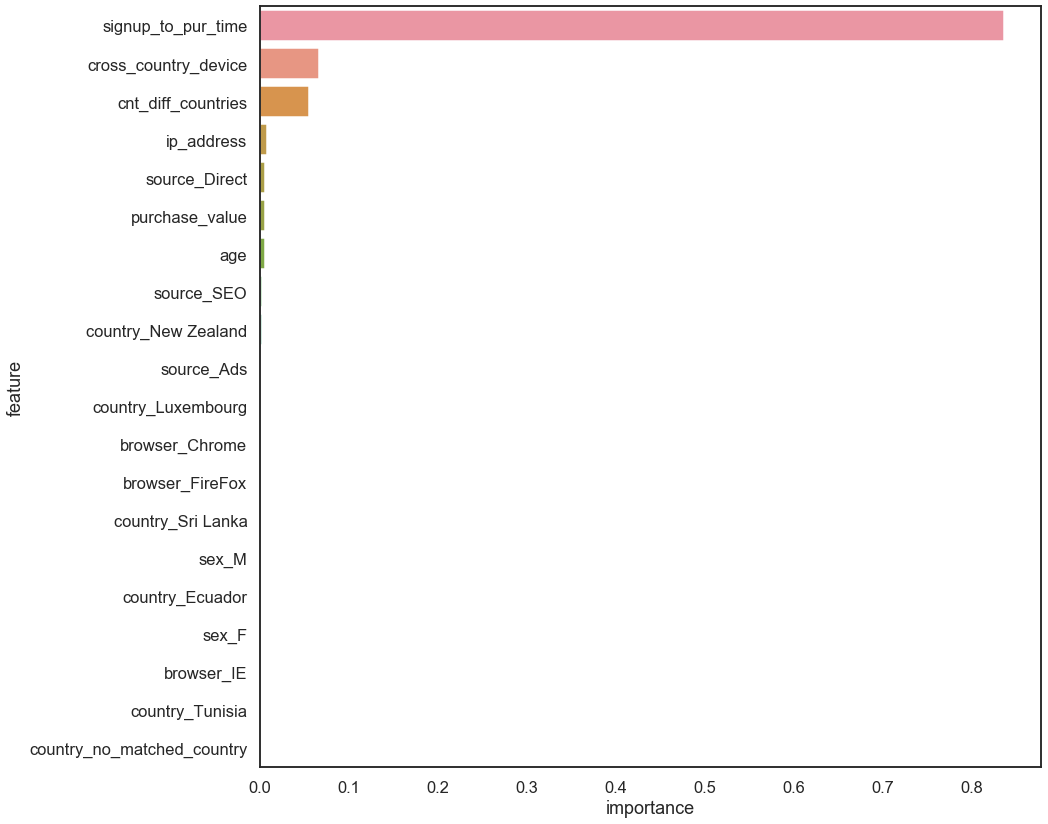

In [424]:
fig = plt.figure(figsize = (14,14))
sns.barplot(x = "importance", y = "feature", data = fea_imp)

# 5. Evaluation

In [438]:
x_valid = x_valid[x_train.columns]

In [439]:
# Make predictions

train_true = y_train
valid_true = y_valid
train_pred = rf_clf_best.predict(x_train)
valid_pred = rf_clf_best.predict(x_valid)

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

In [447]:
# F1-score = 2 * precision*recall / (precision+recall)
print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.1).astype(int),target_names = ["Not Fraud:0","Fraud:1"]))

              precision    recall  f1-score   support

 Not Fraud:0       0.95      0.98      0.97     27373
     Fraud:1       0.73      0.55      0.62      2850

    accuracy                           0.94     30223
   macro avg       0.84      0.76      0.80     30223
weighted avg       0.93      0.94      0.93     30223



In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(valid_fpr, valid_tpr, label='Test AUC: ' + str(valid_auc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()